In [6]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [7]:
######################
# 1) Helper Functions
######################

def parse_yolo_label(txt_file, img_width, img_height):
    """
    YOLO 라벨 형식: <class> <x_center> <y_center> <width> <height>
    (모두 0~1 정규화 값)
    """
    boxes = []
    with open(txt_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if not line:
                continue
            cls_id, x_c, y_c, w, h = line.split()
            cls_id = int(cls_id)
            x_c, y_c, w, h = map(float, [x_c, y_c, w, h])
            
            # 정규화된 좌표 → 실제 픽셀 좌표
            x_center_abs = x_c * img_width
            y_center_abs = y_c * img_height
            w_abs = w * img_width
            h_abs = h * img_height

            x1 = x_center_abs - w_abs / 2
            y1 = y_center_abs - h_abs / 2
            x2 = x_center_abs + w_abs / 2
            y2 = y_center_abs + h_abs / 2

            boxes.append((cls_id, x1, y1, x2, y2))
    return boxes


def compute_iou(box1, box2):
    """
    box1, box2: (x1, y1, x2, y2) 형태의 절대 좌표
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_w = max(0, x2 - x1)
    inter_h = max(0, y2 - y1)
    inter_area = inter_w * inter_h

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / (union_area + 1e-6)
    return iou

In [10]:
def parse_yolo_label(txt_file, img_width, img_height):
    """
    YOLO 라벨 형식:
    <class> <x_center> <y_center> <width> <height>
    (모두 0~1 사이의 정규화 값)

    txt_file: 라벨 파일 경로
    img_width, img_height: 이미지 실제 해상도
    return: [(class_id, x1, y1, x2, y2), ...]
    """
    boxes = []
    with open(txt_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if not line:
                continue
            cls_id, x_c, y_c, w, h = line.split()
            cls_id = int(cls_id)
            x_c, y_c, w, h = map(float, [x_c, y_c, w, h])
            
            # 정규화된 좌표 → 실제 픽셀 좌표
            x_center_abs = x_c * img_width
            y_center_abs = y_c * img_height
            w_abs = w * img_width
            h_abs = h * img_height

            x1 = x_center_abs - w_abs / 2
            y1 = y_center_abs - h_abs / 2
            x2 = x_center_abs + w_abs / 2
            y2 = y_center_abs + h_abs / 2

            boxes.append((cls_id, x1, y1, x2, y2))
    return boxes


def main():
    # 1) 폴더 설정
    image_folder = r"C:\Users\USER\Desktop\my_git\safebaby-xai\yolov8_explain\Baby_Monitoring.v4i.yolov8\valid\images"  # 이미지 폴더
    label_folder = r"C:\Users\USER\Desktop\my_git\safebaby-xai\yolov8_explain\Baby_Monitoring.v4i.yolov8\valid\labels"  # 라벨(.txt) 폴더

    #모델 로드
    model = YOLO(r"C:\Users\USER\Desktop\my_git\safebaby-xai\yolov8_explain\runs\detect\train2\weights\best.pt")

    # 2) 폴더에서 파일 목록 수집 & 정렬
    image_files = [f for f in os.listdir(image_folder) if f.endswith(".jpg")]
    label_files = [f for f in os.listdir(label_folder) if f.endswith(".txt")]

    # 정렬
    image_files.sort()
    label_files.sort()

    if len(image_files) != len(label_files):
        raise ValueError("이미지와 라벨 파일 개수가 다릅니다. 매칭 불가.")

    # 클래스 이름 매핑 (필요 시)
    label_dict = {
        0: 'baby',
        1: 'close eye',
        2: 'crib',
        3: 'mouth',
        4: 'nose',
        5: 'opened eyes'
    }

    iou_data = []

    # (D) 각 이미지 & 라벨 매칭
    for i in range(len(image_files)):
        img_name = image_files[i]
        txt_name = label_files[i]

        img_path = os.path.join(image_folder, img_name)
        txt_path = os.path.join(label_folder, txt_name)

        # 이미지 로드
        img = cv2.imread(img_path)
        if img is None:
            print(f"이미지 로드 실패: {img_path}")
            continue

        height, width, _ = img.shape

        # 라벨(정답) 파싱
        gt_boxes = parse_yolo_label(txt_path, width, height)
        # gt_boxes 예: [(cls_id, x1, y1, x2, y2), ...]

        # 모델 예측
        results = model(img_path)
        # YOLOv8 예측 박스
        pred_boxes = results[0].boxes.xyxy.cpu().numpy()  # (n, 4)
        pred_cls = results[0].boxes.cls.cpu().numpy()     # (n,)

        # (E) 매칭 & IOU 계산
        # 간단히: 각 예측 박스를 모든 GT와 비교 → 클래스 동일 시 IOU 최대값 사용
        for j, pbox in enumerate(pred_boxes):
            p_cls = int(pred_cls[j])
            best_iou = 0.0
            for (g_cls, gx1, gy1, gx2, gy2) in gt_boxes:
                if g_cls == p_cls:  # 클래스 동일
                    iou_val = compute_iou((pbox[0], pbox[1], pbox[2], pbox[3]), (gx1, gy1, gx2, gy2))
                    if iou_val > best_iou:
                        best_iou = iou_val
            
            if best_iou > 0:
                # iou_data에 (class, iou) 저장
                iou_data.append((p_cls, best_iou))

    # (F) DataFrame으로 변환
    df_iou = pd.DataFrame(iou_data, columns=["class_id", "iou"])
    df_iou["class_name"] = df_iou["class_id"].map(label_dict)

    # 저장장
    df_iou.to_csv("iou_results.csv", index=False)
    print("IOU 분석 결과가 iou_results.csv로 저장되었습니다.")

if __name__ == "__main__":
    main()



image 1/1 C:\Users\USER\Desktop\my_git\safebaby-xai\yolov8_explain\Baby_Monitoring.v4i.yolov8\valid\images\-2022-11-18-7-16-58_png_jpg.rf.3cd72d600c423799f5d6a09e83f72489.jpg: 640x640 (no detections), 327.2ms
Speed: 2.8ms preprocess, 327.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\USER\Desktop\my_git\safebaby-xai\yolov8_explain\Baby_Monitoring.v4i.yolov8\valid\images\-kk_jpg.rf.60b24370320df16d3d8a4a0252921a25.jpg: 640x640 1 baby, 1 mouth, 1 nose, 2 opened eyess, 325.8ms
Speed: 3.2ms preprocess, 325.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\USER\Desktop\my_git\safebaby-xai\yolov8_explain\Baby_Monitoring.v4i.yolov8\valid\images\010_jpeg_jpg.rf.5422286c5f0de6bfe4b8db01c309318d.jpg: 640x640 1 baby, 1 mouth, 1 nose, 2 opened eyess, 321.0ms
Speed: 2.3ms preprocess, 321.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\USER\Desktop\my_git\safebaby-xai\yolov8_exp

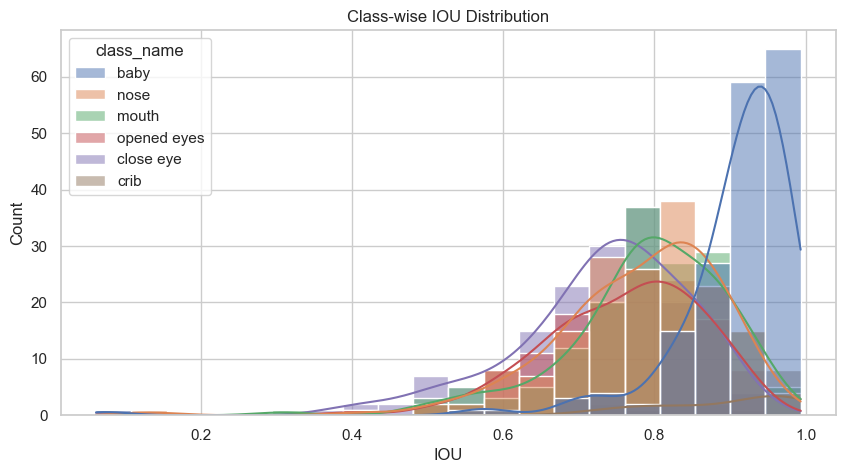

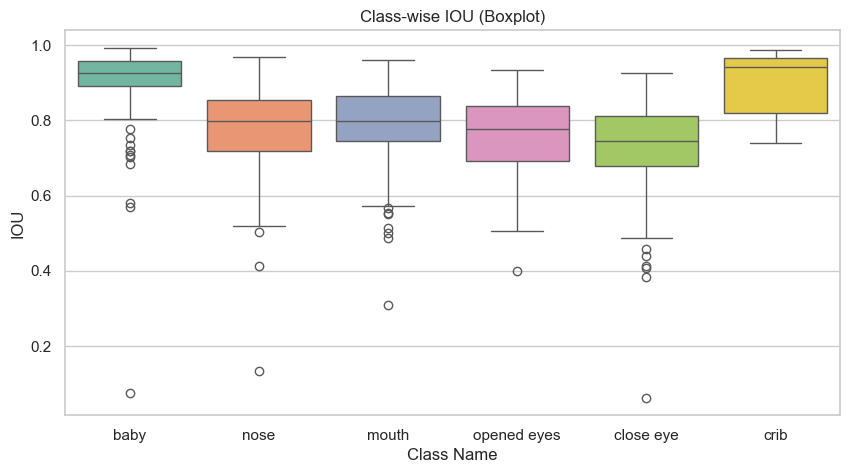

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

df_iou = pd.read_csv("iou_results.csv")


class_order = ["baby", "nose", "mouth", "opened eyes", "close eye", "crib"]

# 테마
sns.set_theme(style="whitegrid")

# IOU 히스토그램
plt.figure(figsize=(10, 5))
sns.histplot(df_iou, x="iou", hue="class_name", bins=20, kde=True, hue_order=class_order)
plt.xlabel("IOU")
plt.ylabel("Count")
plt.title("Class-wise IOU Distribution")
plt.show()

#IOU 박스플롯
plt.figure(figsize=(10, 5))
sns.boxplot(x="class_name", y="iou", data=df_iou, hue="class_name", hue_order=class_order, order=class_order, palette="Set2")
plt.title("Class-wise IOU (Boxplot)")
plt.xlabel("Class Name")
plt.ylabel("IOU")
plt.show()